# How To Write A Hydro Code

Michael Zingale

There are _many_ methods for solving the equations of hydrodynamics.  We will make some choices right from the start:

  * We will consider **finite-volume methods**.  These are popular in astrophysics because they are based on the integral form of the conservative equations and properly conserve mass, momentum, and energy.
  
  * We will look at a simple 2nd order **method-of-lines** integration.  We do this for simplicity here, and will point out where things are commonly done differently.  This scheme has a much simpler spatial reconstruction and relies on an integrator (like a Runge-Kutta method) to advance in time.
  
  * We will work in 1-d.
  
  * We won't cover in detail how to write a Riemann solver (that's a math exercise as much as anything else and beyond the scope of this notebook).
  
  * We'll assume a gamma-law equation of state--this is often not the case in astrophysics.
    
Much more in-depth details and derivations are given in my hydro notes available online: https://github.com/Open-Astrophysics-Bookshelf/numerical_exercises

For a greater variety of methods, in 2-d, see the pyro code: https://github.com/python-hydro/pyro2 (ref: [Harpole et al. JOSS](http://joss.theoj.org/papers/10.21105/joss.01265))

## Overview

We'll focus on the Euler equations.  In 1-d, these are:

\begin{align*}
  \frac{\partial \rho}{\partial t} + \frac{\partial (\rho u)}{\partial x} & = 0 \\
  \frac{\partial (\rho u)}{\partial t} + \frac{\partial (\rho u^2 + p)}{\partial x} &= 0 \\
  \frac{\partial (\rho E)}{\partial t} + \frac{\partial (u(\rho E + p))}{\partial x} &= 0 \\
  \end{align*}

This is a set of (hyperbolic) partial differential equations.  To close the system, we need an equation of state, relating the specific internal energy, $e$, to the pressure:
\begin{align*}
e &= E - \frac{1}{2}u^2 \\
p &= \rho e (\gamma - 1)
\end{align*}
To solve these, we need to discretize the equations in both space and time.  We'll use grid-based methods (in addition to the finite-volume method we'll consider, this can include finite-difference and finite-element methods).  

Our system of equations can be expressed in conservative form:
$$ \frac{\partial U}{\partial t} + \frac{\partial F(U)}{\partial x} = 0$$
where $U = (\rho, \rho u, \rho E)^\intercal$.

In a finite-volume method, we store the state of the fluid in discrete volumes in space, and we can refer to this discretized state with an index.  To see this, we integrate the conservative law system in space over a volume $[x_{i-1/2},x_{i+1/2}]$:
$$\frac{\partial \langle U\rangle_i}{\partial t} = - \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x}$$

This is the form of the equations we will solve.  Here, $\langle U\rangle_i$ represents the average state of the fluid in a volume:
$$\langle U\rangle_i = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} U(x) dx$$
Visually, we usually think of this grid as:

![FV grid](fv_grid.png)

The state on the grid represents an instance in time.  We evolve the state by computing the fluxes through the volumes.  These fluxes tell us how much the state changes in each volume over some small timestep, $\Delta t$.  

Our code will have the following structure:

  * Create our numerical grid
  
  * Set the initial conditions
  
  * Main timestep evolution loop
  
    * Compute the timestep
    
    * Time-integation loop (depends on the number of stages in the integrator)
  
        * Reconstruct the state to interfaces
    
        * Solve Riemann problem to find the fluxes through the interface
    
        * Do a conservative update of the state to the stage
    
    * Output

## Grid

We'll manage our 1-d grid via a class `FVGrid`.  We will divide the domain into a number of zones (or volumes) that will store the state.  To implement boundary conditions, we traditionally use ghost cells--extra cells added to each end of the domain.  We'll consider a grid that looks like this:

![grid w ghostcells](simplegrid_gc.png)

We'll use the names `lo` and `hi` to refer to the first and last zone in our domain.  The domain boundaries are the bold lines shown above, and beyond that, on each end, we have ghost cells.

The main information we need to setup the grid are the number of zones in the interior and the number of ghost cells.

In [1]:
import numpy as np

To make life easier, we'll have a simple class with indices that we use to index the fluid state arrays.  We can pass this around and be sure that we are always accessing the correct fluid state.

In [2]:
class FluidVars:
    """A simple container that holds the integer indicies we will use to refer to
    the different fluid components"""
    def __init__(self, gamma=1.4, C=0.8):
        self.nvar = 3
    
        # conserved variables
        self.urho = 0
        self.umx = 1
        self.uener = 2
    
        # primitive variables
        self.qrho = 0
        self.qu = 1
        self.qp = 2
    
        # EOS gamma
        self.gamma = gamma
        
        # CFL number
        self.C = C

This is the main class for managing the finite-volume grid.  In addition to holding coordinate information and knowing the bounds of the domain, it also can fill the ghost cells and give you a scratch array that lives on the same grid.

In [3]:
class FVGrid:
    """The main finite-volume grid class for holding our fluid state."""
    
    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # Make easy intergers to know where the real data lives
        self.lo = ng
        self.hi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

    def scratch_array(self, nc=1):
        """ return a scratch array dimensioned for our grid """
        if nc == 1:
            return np.zeros((self.nx+2*self.ng), dtype=np.float64)
        else:
            return np.zeros((self.nx+2*self.ng, nc), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all ghost cells with zero-gradient boundary conditions """

        if atmp.ndim == 2:
            nc = atmp.shape[1]
            for n in range(nc):
                atmp[0:self.lo, n] = atmp[self.lo, n]
                atmp[self.hi+1:, n] = atmp[self.hi, n]            
        else:
            atmp[0:self.lo] = atmp[self.lo]
            atmp[self.hi+1:] = atmp[self.hi]

## Reconstruction

We need to use the cell-averages to figure out what the fluid state is on the interfaces.  We'll _reconstruct_ the cell-averages as piecewise lines that give us the same average in the zone.  We then follow these lines to the interfaces to define the left and right state at each interface.

Usually we work in terms of the **primitive variables**, $q = (\rho, u, p)$.  So we first write a routine to do the algebraic transformation from conservative to primitive variables:

In [4]:
def cons_to_prim(grid, U):
    """take a conservative state U and return the corresponding primitive variable state as a 
    new array."""
    v = FluidVars()
    q = grid.scratch_array(nc=v.nvar)

    q[:, v.qrho] = U[:, v.urho]
    q[:, v.qu] = U[:, v.umx]/U[:, v.urho]
    q[:, v.qp] = (U[:, v.uener] - 0.5*q[:, v.qrho]*q[:, v.qu]**2)*(v.gamma - 1.0)
    return q

Next we need a routine to create the interface states.  Here's well construct a slope for each zone, $\Delta q$ based on the average state in the neighboring zones.  This gives us a line representing the value of the fluid state as a function of position in each zone:
$$q_i(x) = \langle q\rangle_i + \frac{\Delta q_i}{\Delta x} (x - x_i)$$
Note that there is a unique $q_i(x)$ for each zone--this is usually called _piecewise linear reconstruction_.  By design, the average of $q_i(x)$ over the zone is the cell-average, so it is conservative.

We use this equation for a line to find the fluid state right at the interface.  For zone $i$, the line $q_i(x)$ gives you the right state on the left interface, $q_{i-1/2,R}$, and the left state on the right interface, $q_{i+1/2,L}$.  Visually this looks like:

![finding interface states](riemann_bc.png)

There's one additional wrinkle--2nd order codes tend to produce oscillations near discontinuities, so we usually need to _limit_ the slopes, $\Delta q_i$, so we don't introduce new minima or maxima in the evolution.

In [5]:
def states(grid, U):
    v = FluidVars()
    q = cons_to_prim(grid, U)

    # construct the slopes
    dq = grid.scratch_array(nc=v.nvar)

    for n in range(v.nvar):
        
        dl = grid.scratch_array()
        dr = grid.scratch_array()

        dl[grid.lo-1:grid.hi+2] = q[grid.lo:grid.hi+3,n] - q[grid.lo-1:grid.hi+2,n]
        dr[grid.lo-1:grid.hi+2] = q[grid.lo-1:grid.hi+2,n] - q[grid.lo-2:grid.hi+1,n]

        # these where's do a minmod()
        d1 = np.where(np.fabs(dl) < np.fabs(dr), dl, dr)
        dq[:, n] = np.where(dl*dr > 0.0, d1, 0.0)

        # unlimited centered slopes
        #dq[grid.ilo-1:grid.ihi+2,n] = 0.5*(q[grid.ilo:grid.ihi+3,n] - q[grid.ilo-2:grid.ihi+1,n])

    # now make the states
    q_l = grid.scratch_array(nc=v.nvar)
    q_l[grid.lo:grid.hi+2, :] = q[grid.lo-1:grid.hi+1, :] + 0.5*dq[grid.lo-1:grid.hi+1, :]

    q_r = grid.scratch_array(nc=v.nvar)
    q_r[grid.lo:grid.hi+2, :] = q[grid.lo:grid.hi+2, :] - 0.5*dq[grid.lo:grid.hi+2, :]
    
    return q_l, q_r

## Riemann problem and conservative update

After doing our reconstruction, we are left with a left and right state on an interface.  To find the unique fluid state on the interface, we solve a _Riemann problem_, 
$$q_{i+1/2} = \mathcal{R}(q_{i+1/2,L},q_{i+1/2,R})$$

We could spend an entire day talking about how to solve the Riemann problem.  The basic idea is that at each interface, we have a left and right state.  Information about the jump across this interface will be carried away from the interface by the 3 hydrodynamic waves ($u$ and $u\pm c$).  The solution to the Riemann problem that we need is the state on the interface--with that we can evaluate the flux through the interface.  

To solve the Riemann problem, we need to know how much each variable changes across each of the three waves.  To complicate matters, the left and right waves can be either shocks or rarefactions.  The middle wave ($u$) is always a contact discontinuity (and of our primitive variables, only $\rho$ jumps across it).

For a gamma-law gas, we can write down analytic expressions for the change in the primitive variables across both a rarefaction and shock.  We can then solve these to find the state inbetween the left and right waves, and then compute the wave speeds to find the solution on the interface.  The exact Riemann solution is somewhat expensive to compute, so we often use approximations.  Here we'll import a solver that uses the _two-shock approximation_.

In [6]:
import riemann

In [7]:
help(riemann.riemann)

Help on function riemann in module riemann:

riemann(q_l, q_r, gamma)
    solve the Riemann problem given left and right primitive variable
    states.  We return the flux



For a method-of-lines approach, we want to just compute the righthand side, $A = -\partial F/\partial x$.  This routine will take the conserved state, $U$, construct the left and right states at all interfaces, solve the Riemann problem to get the unique state on the boundary, and then compute the advective term and return it.

In [8]:
def make_flux_divergence(grid, U):
    
    v = FluidVars()
    
    # get the states
    q_l, q_r = states(grid, U)

    # now solve the Riemann problem
    flux = grid.scratch_array(nc=v.nvar)
    for i in range(grid.lo, grid.hi+2):
        flux[i, :] = riemann.riemann(q_l[i, :], q_r[i, :], v.gamma)

    A = grid.scratch_array(nc=v.nvar)
    for n in range(v.nvar):
        A[grid.lo:grid.hi+1, n] = (flux[grid.lo:grid.hi+1, n] -
                                   flux[grid.lo+1:grid.hi+2, n])/grid.dx

    return A

## Timestep

In [9]:
def timestep(grid, U):

    v = FluidVars()
    
    # compute the sound speed
    q = cons_to_prim(grid, U)
    c = grid.scratch_array()
    c[grid.lo:grid.hi+1] = np.sqrt(v.gamma *
                                   q[grid.lo:grid.hi+1,v.qp] /
                                   q[grid.lo:grid.hi+1,v.qrho])

    dt = v.C * grid.dx / (np.abs(q[grid.lo:grid.hi+1, v.qu]) + c[grid.lo:grid.hi+1]).max()
    return dt

## Main driver

In [10]:
def mol_solve(nx):

    grid = FVGrid(nx, 2)
    v = FluidVars()
    
    U = grid.scratch_array(nc=v.nvar)

    # setup initial conditions -- this is Sod's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 1.0
    rho_r = 0.125
    u_r = 0.0
    p_r = 0.1

    idx_l = grid.x < 0.5
    idx_r = grid.x >= 0.5

    U[idx_l, v.urho] = rho_l
    U[idx_l, v.umx] =  rho_l * u_l
    U[idx_l, v.uener] = p_l/(v.gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, v.urho] = rho_r
    U[idx_r, v.umx] =  rho_r * u_r
    U[idx_r, v.uener] = p_r/(v.gamma - 1.0) + 0.5 * rho_r * u_r**2

    t = 0.0
    tmax = 0.2
    
    while t < tmax:

        # compute the timestep
        dt = timestep(grid, U)

        if t + dt > tmax:
            dt = tmax - t

        print(t, dt, U.max())
        # second-order RK integration
        grid.fill_BCs(U)
        k1 = make_flux_divergence(grid, U)

        U_tmp = grid.scratch_array(nc=v.nvar)
        for n in range(v.nvar):
            U_tmp[:, n] = U[:, n] + 0.5 * dt * k1[:, n]

        grid.fill_BCs(U_tmp)
        k2 = make_flux_divergence(grid, U_tmp)

        for n in range(v.nvar):
            U[:, n] += dt * k2[:, n]

        t += dt

    return U

## Example: Sod's problem

In [11]:
U = mol_solve(128)

0.0 0.005282214092053229 2.5000000000000004
0.005282214092053229 0.0030803034858341736 2.5000000000000004
0.008362517577887403 0.003103750440072892 2.5000000000000004
0.011466268017960295 0.003139160775492315 2.5000000000000004
0.01460542879345261 0.0030818242240249244 2.5000000000000004
0.017687253017477533 0.003049172271190417 2.5000000000000004
0.02073642528866795 0.0030331822389496974 2.5000000000000004
0.02376960752761765 0.0030012497235222626 2.5000000000000004
0.026770857251139913 0.0029374404682974563 2.5000000000000004
0.02970829771943737 0.0029445992617357798 2.5000000000000004
0.03265289698117315 0.002938720569216068 2.5000000000000004
0.03559161755038922 0.0028916678113571344 2.5000000000000004
0.038483285361746354 0.0028758256930138176 2.5000000000000004
0.04135911105476017 0.002887626119770791 2.5000000000000004
0.04424673717453096 0.002883514253865701 2.5000000000000004
0.04713025142839666 0.002860071328459145 2.5000000000000004
0.04999032275685581 0.0028505969131125243 

In [12]:
import matplotlib.pyplot as plt

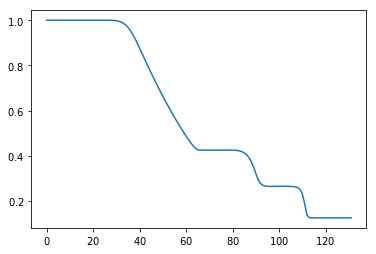

In [14]:
v = FluidVars()
plt.plot(U[:,v.urho])